In [12]:
### import libraries
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
color_pal = sns.color_palette()


In [13]:
# import the dataset to be use
df = pd.read_csv('PJME_hourly.csv')

df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [14]:
# Convert the column to datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])
# Set it as the index
df.set_index('Datetime', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


<Axes: title={'center': ' Energy Consumption'}, xlabel='Datetime'>

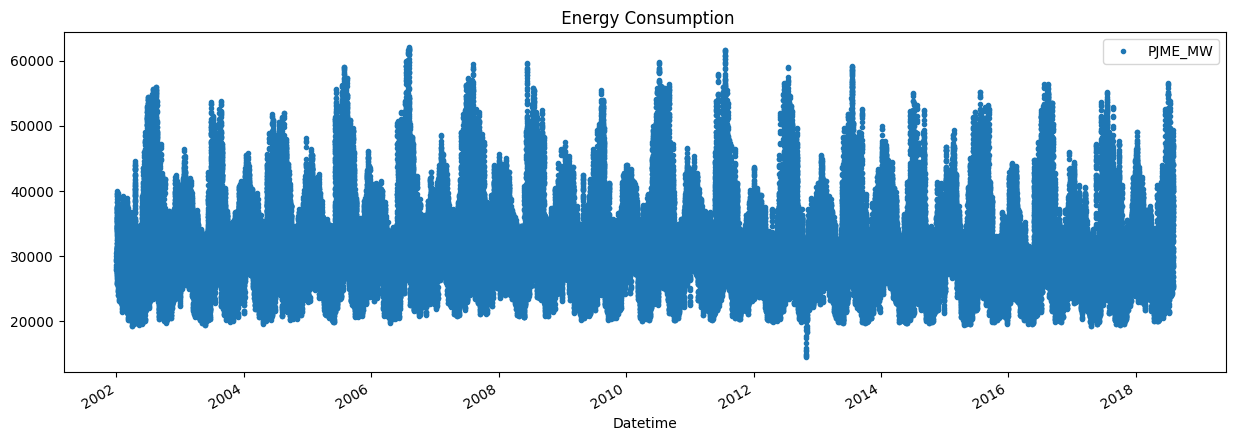

In [15]:
df.plot(style='.',
        figsize=(15,5),
        color = color_pal[0],
        title = ' Energy Consumption')

from the chart, there is a seasonality trend

<Axes: title={'center': 'Week Of Data'}, xlabel='Datetime'>

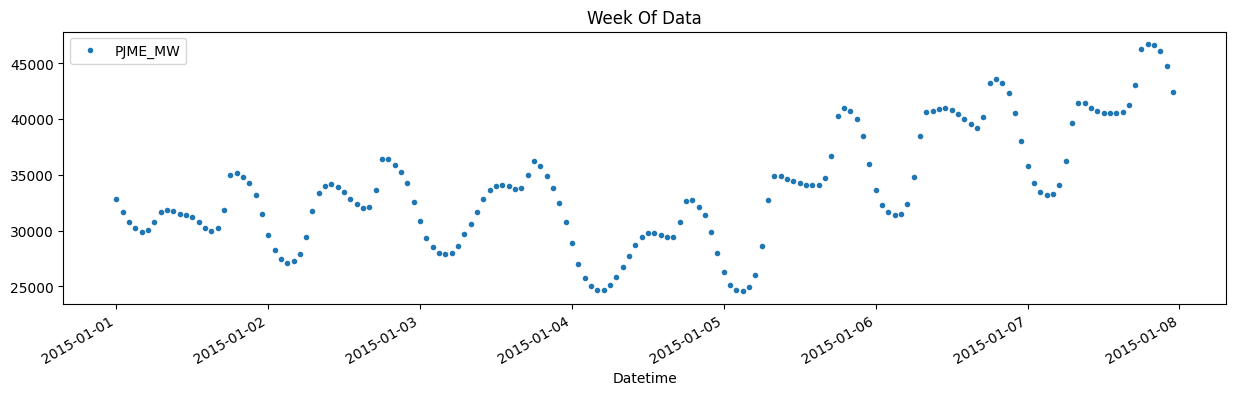

In [ ]:
# zoom in to see the week pattern 
df_week = df.loc[
    (df.index >=  '2015-01-01') & (df.index <  '2015-01-08')
    ]

df_week.plot(style='.', figsize=(15, 4), title='Week Of Data')

# Outlier Analysis and removal


<Axes: ylabel='Frequency'>

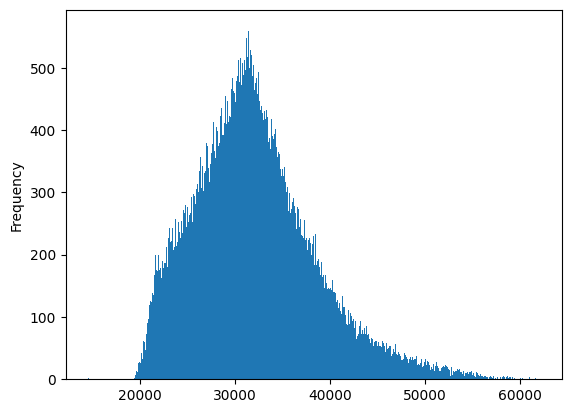

In [18]:
""""
to have better understanding of MW distribution,
we plot a histogram
"""
df['PJME_MW'].plot(kind='hist',
                 bins=1000,)

<Axes: title={'center': 'Outliers in Energy Consumption'}, xlabel='Datetime'>

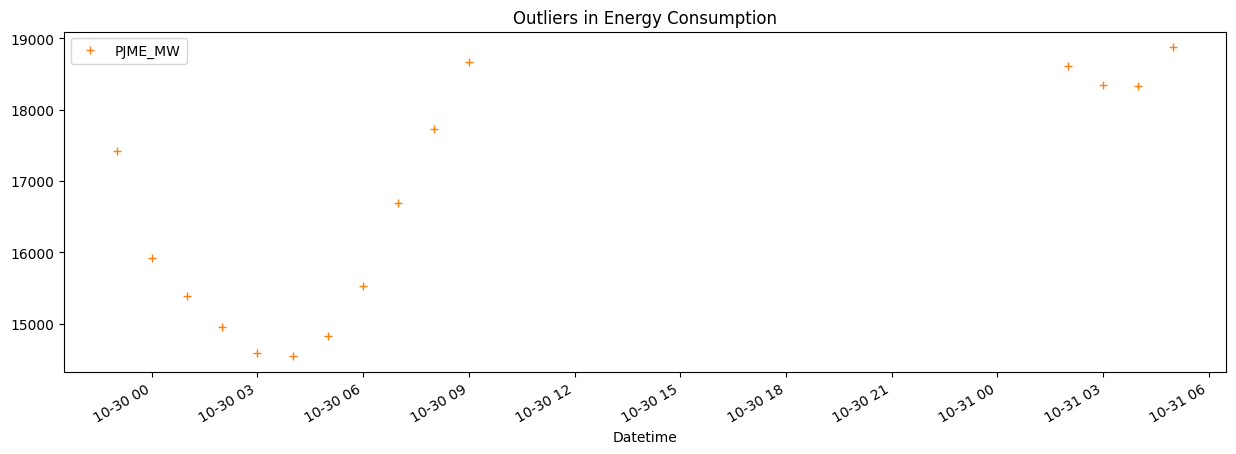

In [19]:
# check frequency of MW below 19k
df.query('PJME_MW < 19000').plot(
    figsize=(15,5), style='+',
    color=color_pal[1],
    title='Outliers in Energy Consumption')

this could be as a result of power outtage

In [20]:
# dropping MW less than 19k
df = df.query('PJME_MW > 19000').copy()

In [22]:
"""
Extract meaningful time-based features so the model can learn daily, weekly, and seasonal patterns.
Converts the datetime index into numeric components that improve forecasting accuracy.
so we create a function to do that.
"""

def ts_features(df):
    df2 = df.copy()
    df2['hour'] = df.index.hour
    df2['dayofweek'] = df.index.dayofweek
    df2['quarter'] = df.index.quarter
    df2['month'] = df.index.month
    df2['year'] = df.index.year
    df2['dayofmonth'] = df.index.day
    df2['dayofyear'] = df.index.dayofyear
    df2['weekofyear'] = df.index.isocalendar().week
    return df2

df2 = ts_features(df)


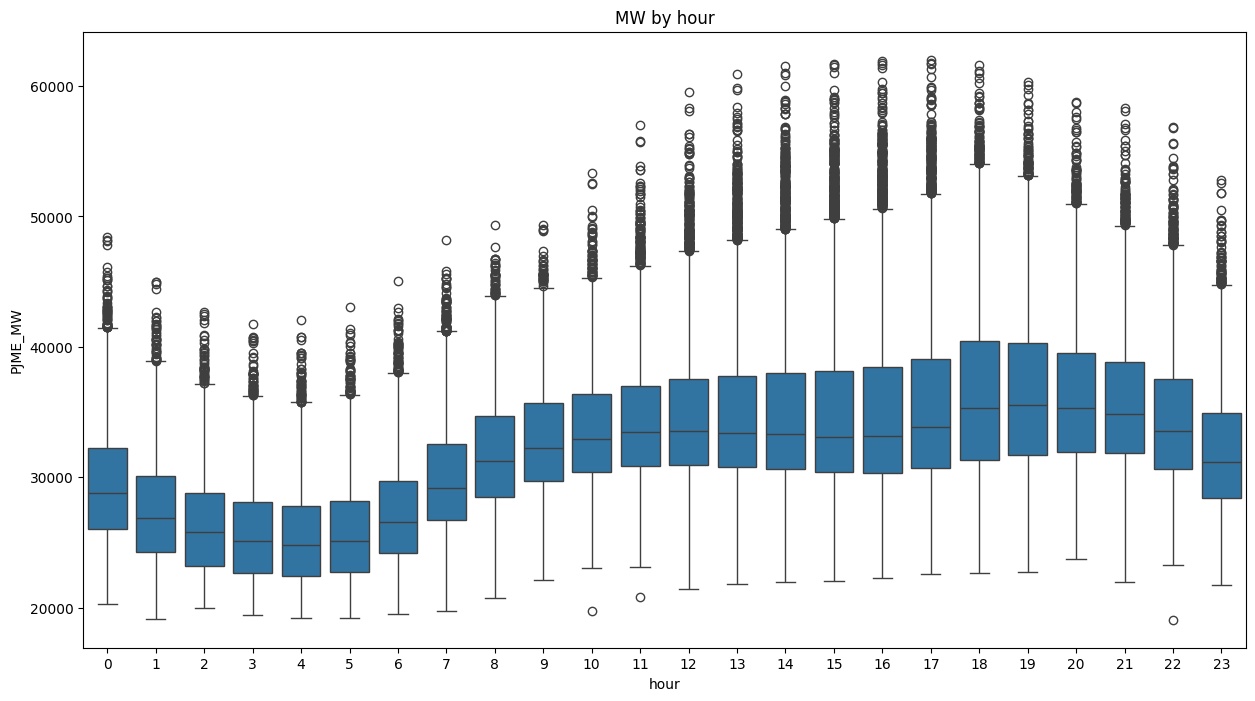

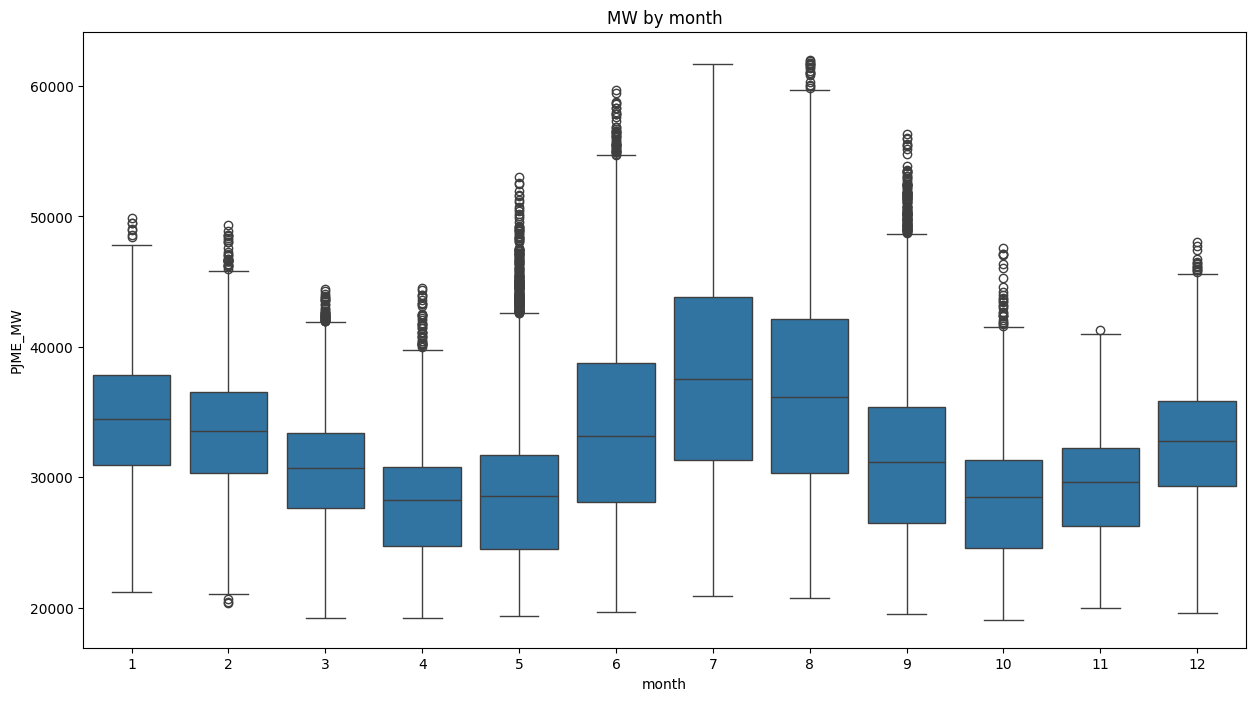

In [23]:
def feature_chart(df, col):
    """
    Plot a boxplot of 'PJME_MW' against a column in df.
    The plot title will automatically use the column name.
    """
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.boxplot(data=df2, x=col, y='PJME_MW', ax=ax)
    ax.set_title(f'MW by {col}')  # use the column name
    plt.show()

# Pass the column name as a string
feature_chart(df2, 'hour')
feature_chart(df2, 'month')


# Train / Test Split

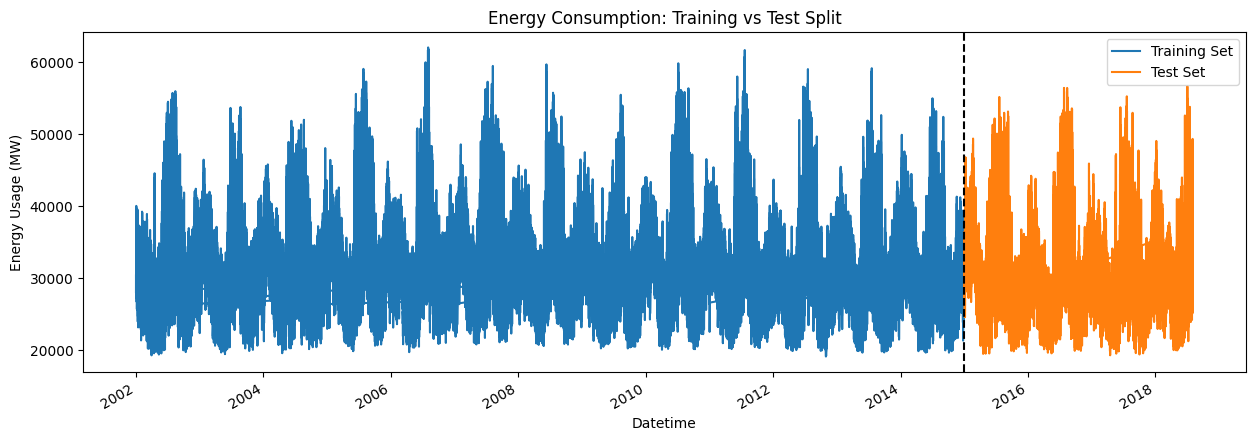

In [26]:
"""
Since it's a time series, we split by date

adding a plot for visual representation
"""
train = df.loc[df.index < '2015-01-01']
test = df.loc[df.index >= '2015-01-01']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')

ax.set_ylabel('Energy Usage (MW)')
ax.set_title('Energy Consumption: Training vs Test Split')

ax.axvline(pd.Timestamp('2015-01-01'), color='black', ls='--')

plt.legend(['Training Set', 'Test Set'])
plt.show()


# Time Series Cross Validation

In [27]:
# TimeSeriesSplit is a special type of cross-validation designed for time-series data.
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145351 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145351 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


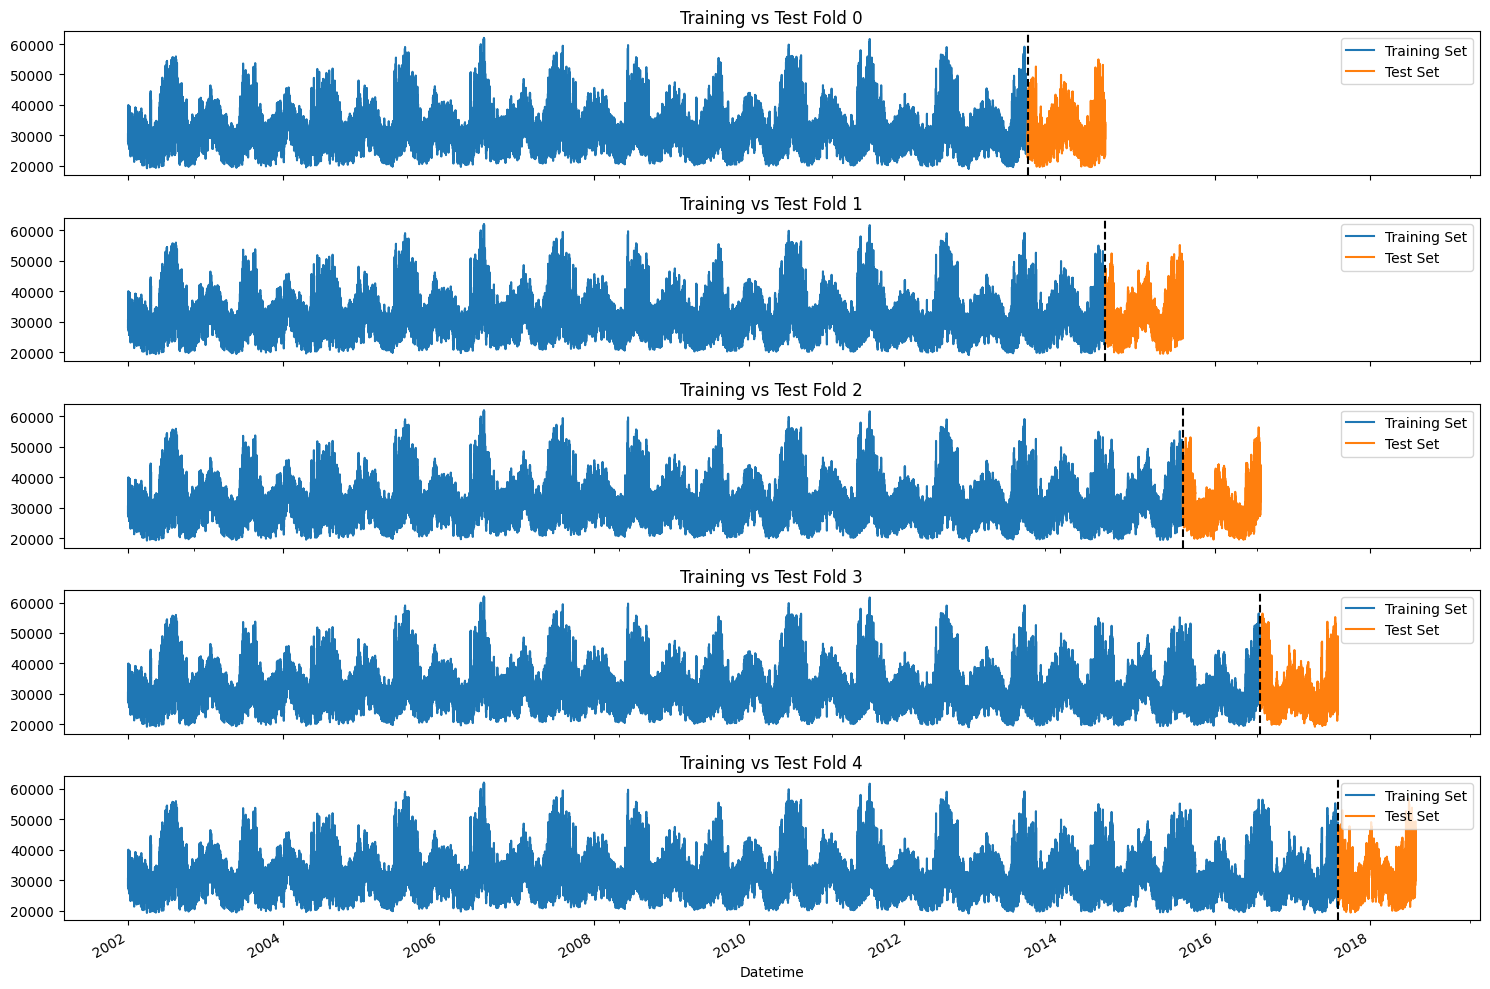

In [28]:
fig, axs = plt.subplots(5, 1, figsize=(15, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train['PJME_MW'].plot(ax=axs[fold], label=f"Training Set")
    test['PJME_MW'].plot(ax=axs[fold], label="Test Set")

    axs[fold].axvline(test.index[0], color='black', ls='--')
    axs[fold].set_title(f"Training vs Test Fold {fold}")


    axs[fold].legend()

    fold += 1

plt.tight_layout()
plt.show()


# Forecasting Horizon Explained
the lenght of time into the future for forecasting

# Lag features
the target days in the past, since the model can't see this on it own, we help to generate the lag to help the model to better understand the pattern

In [29]:
# we create lag features for last year, last 2 and 3 years
def add_lag(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = df['PJME_MW'].shift(364)
    df['lag2'] = df['PJME_MW'].shift(728)
    df['lag3'] = df['PJME_MW'].shift(1092)
    return df

In [30]:
df = ts_features(df)
df = add_lag(df)

In [31]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN


# Create Model

In [ ]:
# features and target variable
FEATURES = ['hour', 'dayofweek', 'quarter',
            'month','dayofyear',
            'lag1','lag2','lag3']

TARGET = 'PJME_MW'

In [33]:
fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
# add time series cross validation
    train = ts_features(train)
    test = ts_features(test)

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32733.72281	validation_1-rmse:31957.46719


c:\Users\zeid9\Documents\Time-series-forecast-with-XGB\forecast\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:47:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12622.55413	validation_1-rmse:11994.98940
[200]	validation_0-rmse:5838.55011	validation_1-rmse:5464.72357
[300]	validation_0-rmse:3924.07611	validation_1-rmse:3920.48122
[400]	validation_0-rmse:3458.46101	validation_1-rmse:3694.47351
[500]	validation_0-rmse:3314.63715	validation_1-rmse:3666.50055
[550]	validation_0-rmse:3276.16196	validation_1-rmse:3667.53352
[0]	validation_0-rmse:32673.41187	validation_1-rmse:32139.90638


c:\Users\zeid9\Documents\Time-series-forecast-with-XGB\forecast\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:47:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12616.31992	validation_1-rmse:12215.09448
[200]	validation_0-rmse:5851.90688	validation_1-rmse:5648.56991
[300]	validation_0-rmse:3951.54923	validation_1-rmse:4052.57888
[400]	validation_0-rmse:3493.07707	validation_1-rmse:3791.92052
[500]	validation_0-rmse:3351.25984	validation_1-rmse:3713.71849
[600]	validation_0-rmse:3283.49807	validation_1-rmse:3691.35337
[700]	validation_0-rmse:3240.08875	validation_1-rmse:3672.35769
[800]	validation_0-rmse:3209.43876	validation_1-rmse:3654.18595
[900]	validation_0-rmse:3186.73593	validation_1-rmse:3636.85234
[999]	validation_0-rmse:3168.26785	validation_1-rmse:3621.45380
[0]	validation_0-rmse:32632.51220	validation_1-rmse:31076.29623


c:\Users\zeid9\Documents\Time-series-forecast-with-XGB\forecast\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:47:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12609.54311	validation_1-rmse:11276.73573
[200]	validation_0-rmse:5863.78737	validation_1-rmse:4906.52042
[300]	validation_0-rmse:3965.92201	validation_1-rmse:3584.66119
[400]	validation_0-rmse:3516.04054	validation_1-rmse:3500.04702
[421]	validation_0-rmse:3476.00071	validation_1-rmse:3504.11787
[0]	validation_0-rmse:32529.79492	validation_1-rmse:31470.74421


c:\Users\zeid9\Documents\Time-series-forecast-with-XGB\forecast\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:48:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12578.35937	validation_1-rmse:11777.43687
[200]	validation_0-rmse:5861.69880	validation_1-rmse:5516.47883
[300]	validation_0-rmse:3976.56119	validation_1-rmse:4140.82281
[400]	validation_0-rmse:3536.86941	validation_1-rmse:3980.40996
[467]	validation_0-rmse:3425.18390	validation_1-rmse:3980.06921
[0]	validation_0-rmse:32463.45581	validation_1-rmse:31462.00340


c:\Users\zeid9\Documents\Time-series-forecast-with-XGB\forecast\Lib\site-packages\xgboost\callback.py:386: UserWarning: [19:48:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[100]	validation_0-rmse:12570.66131	validation_1-rmse:11802.58606
[200]	validation_0-rmse:5878.58133	validation_1-rmse:5491.59041
[300]	validation_0-rmse:4005.56214	validation_1-rmse:4107.03228
[400]	validation_0-rmse:3567.83073	validation_1-rmse:3944.06436
[487]	validation_0-rmse:3443.11425	validation_1-rmse:3934.90039


In [34]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3738.7348
Fold scores:[np.float64(3666.5005551061886), np.float64(3621.4538034174025), np.float64(3495.66853975225), np.float64(3975.639479483308), np.float64(3934.4118120429753)]


In [35]:
# Retrain on all data
df = ts_features(df)

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32405.29765


c:\Users\zeid9\Documents\Time-series-forecast-with-XGB\forecast\Lib\site-packages\xgboost\training.py:199: UserWarning: [19:52:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:282: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


[100]	validation_0-rmse:12559.07157
[200]	validation_0-rmse:5894.47794
[300]	validation_0-rmse:4041.42336
[400]	validation_0-rmse:3607.57992
[499]	validation_0-rmse:3478.22201


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [38]:
"""get the last date in the dataset to determin when are forecast starting from,
and setting the time range for forecasting to 1 years
"""
future_df = pd.date_range(
    start=df.index.max() + pd.Timedelta(hours=1),
    end=df.index.max() + pd.Timedelta(days=365, hours=1),
    freq='h'
)

future_df = pd.DataFrame(index=future_df)


In [39]:
# set an empty variable 'isFuture' then concat with the original dataset

future_df['isFuture'] = True
df['isFuture'] = False
df = pd.concat([df, future_df]) # Concatenate future_df to df

In [41]:
# add the features to the dataset and the future dates
df_future = ts_features(df)
df_future = add_lag(df_future)


#select the future dates only
future_features = df_future.query('isFuture').copy()
future_features.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofmonth,dayofyear,weekofyear,lag1,lag2,lag3,isFuture
2018-08-03 01:00:00,NaN,1,4,3,8,2018,3,215,31,40363.0,54724.0,47386.0,True
2018-08-03 02:00:00,NaN,2,4,3,8,2018,3,215,31,38647.0,53679.0,49433.0,True
2018-08-03 03:00:00,NaN,3,4,3,8,2018,3,215,31,35276.0,51788.0,50819.0,True
2018-08-03 04:00:00,NaN,4,4,3,8,2018,3,215,31,31896.0,49244.0,51818.0,True
2018-08-03 05:00:00,NaN,5,4,3,8,2018,3,215,31,29092.0,47292.0,52558.0,True


# Predict the future hourly Energy usage

In [47]:
future_features['prediction'] = reg.predict(future_features[FEATURES])

<Axes: title={'center': 'Future Predictions'}>

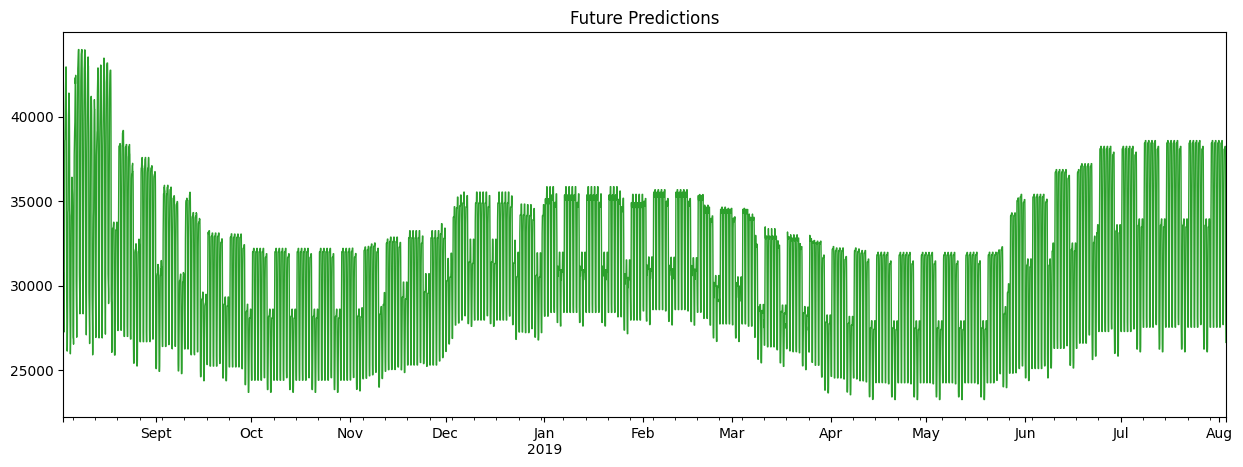

In [48]:
future_features['prediction'].plot(figsize=(15,5), 
                                   color=color_pal[2],
                                   ms = 1,
                                   lw = 1,
                                   title='Future Predictions')

# Save the model

In [49]:
# Save model
reg.save_model('model.json')

# let load and use the model we saved

<Axes: title={'center': 'Future Predictions'}>

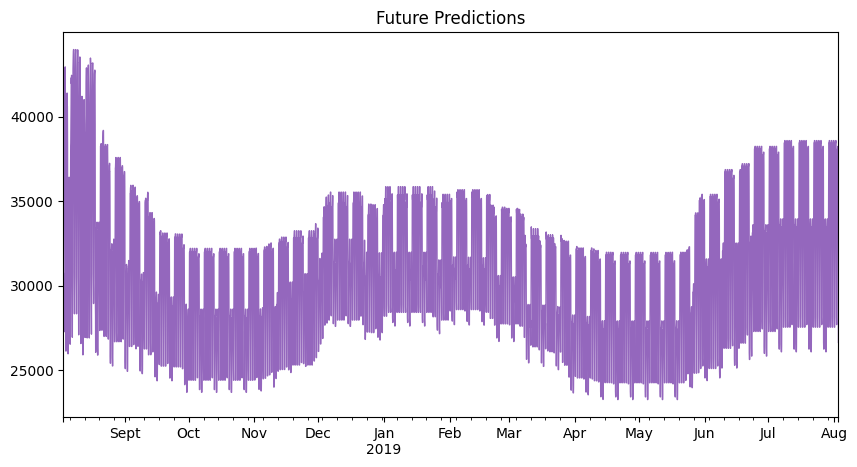

In [50]:
reg_new = xgb.XGBRegressor()

reg_new.load_model('model.json')
future_features['pred'] = reg_new.predict(future_features[FEATURES])

future_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')